In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import random
from scipy.stats import trim_mean
from scipy import stats
from imblearn.combine import SMOTEENN
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, RidgeCV
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE, SelectFromModel

In [2]:
# Import Data
X_train_np = np.load("../VAE_Data/X_train.npy", allow_pickle=True).astype(np.float64)
X_test_np = np.load("../VAE_data/X_test.npy", allow_pickle=True).astype(np.float64)
y_train_np = np.load("../VAE_data/y_train.npy", allow_pickle=True).astype(np.float64)
y_test_np = np.load("../VAE_Data/y_test.npy", allow_pickle=True).astype(np.float64)

X_train_np.shape, X_test_np.shape, y_train_np.shape, y_test_np.shape

((14196, 2640), (1586, 2640), (14196, 1890), (1586, 1890))

In [3]:
# Combine train and test data for scaling
X_combined = np.vstack((X_train_np, X_test_np))
y_combined = np.vstack((y_train_np, y_test_np))

In [4]:
def plotXYrelationship(X: np.array, y: np.array, Xcolumn: int, ycolumn: int):
    assert Xcolumn >= 748 and Xcolumn < 2640
    assert ycolumn < 1890
    plt.figure(figsize=(10,6))
    X_data = X[:, Xcolumn]
    Y_data = y[:, ycolumn]
    colors = np.random.rand(50)
    plt.scatter(X_data, Y_data)
    plt.show()

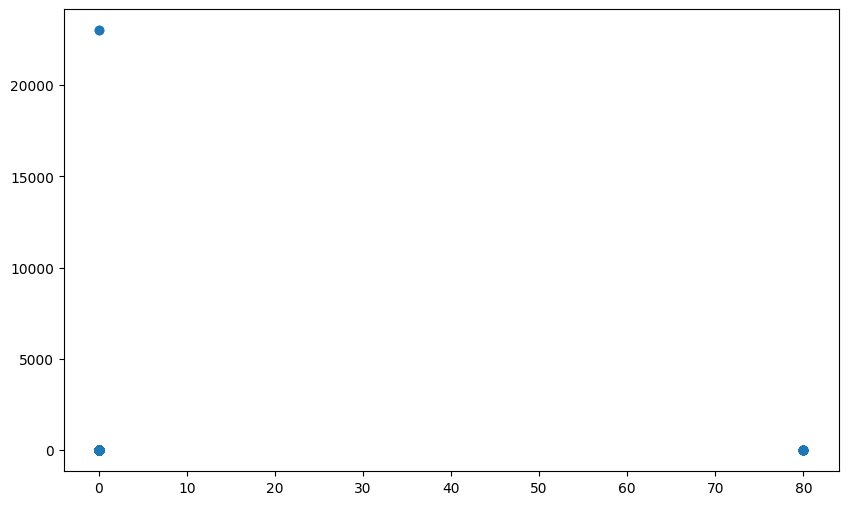

In [5]:
plotXYrelationship(X_combined, y_combined, 2200, 418)

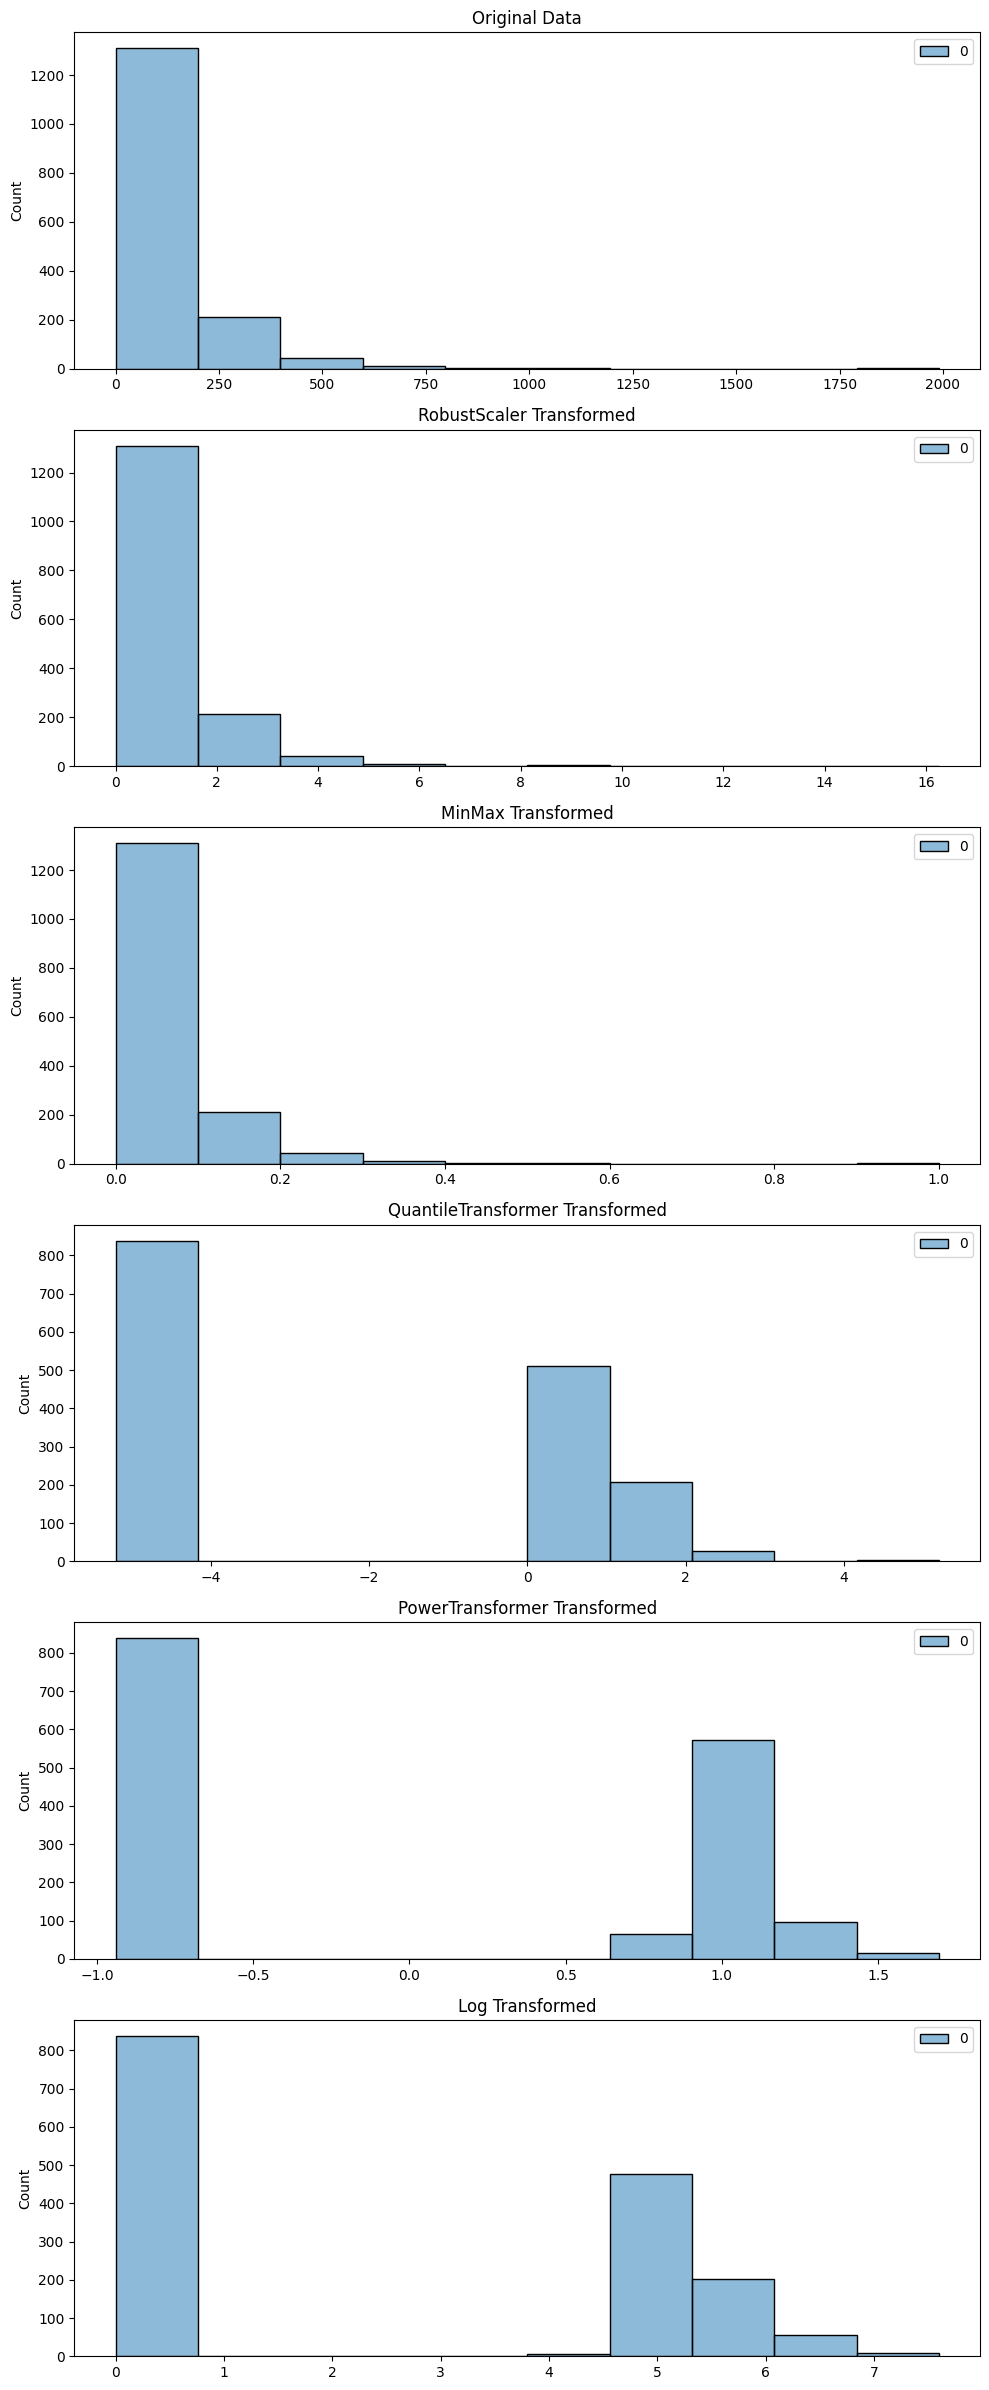

In [6]:
data = y_test_np[:,126].reshape(-1,1)
scalers = {
    'RobustScaler': RobustScaler(unit_variance=True),
    'MinMax': MinMaxScaler(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal'),
    'PowerTransformer': PowerTransformer(method='yeo-johnson'),
    'Log': lambda X: np.log1p(data)
}

fig, axes = plt.subplots(len(scalers) + 1, 1, figsize=(10, 4 * (len(scalers) + 1)))

sns.histplot(data, ax=axes[0], bins=10)
axes[0].set_title('Original Data')

for i, (name, scaler) in enumerate(scalers.items(), 1):
    if callable(scaler):
        X_scaled = scaler(data)
    else:
        X_scaled = scaler.fit_transform(data)
    sns.histplot(X_scaled, ax=axes[i], bins=10)
    axes[i].set_title(f'{name} Transformed')

plt.tight_layout()
plt.show()

In [7]:

# Split the shuffled, scaled data back into train and test sets
#test_size = len(X_test_np) / len(X_combined)  # Calculate the original test set proportion
#X_train, X_test, y_train, y_test = train_test_split(
 #   X_combined, y_combined, test_size=0.3, random_state=42, shuffle=False
#)

X_combined = np.vstack((X_train_np, X_test_np))
y_combined = np.vstack((y_train_np, y_test_np))

# Scale the Data
scaler = RobustScaler()
X_scaled = X_combined.copy()

# Don't scale before 748 because of 1 hot encodings
X_scaled[:, 749:] = scaler.fit_transform(X_combined[:, 749:])
ordinal_days_scaler = MinMaxScaler()
X_scaled[:, 748] = ordinal_days_scaler.fit_transform(X_combined[:, 748].reshape(-1, 1)).ravel()


# Scale y values
y_scaler = RobustScaler()
y_scaled = y_scaler.fit_transform(y_combined)


X_train_scaled = X_scaled[:len(X_train_np),:]
X_test_scaled = X_scaled[len(X_train_np):, :]
y_train_scaled = y_scaled[:len(y_train_np),:]
y_test_scaled = y_scaled[len(y_train_np):,:]

X_train = X_train_np
X_test = X_test_np
y_train = y_train_np
y_test = y_test_np



In [8]:
y_combined.shape

(15782, 1890)

In [9]:
X_train_scaled.shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape

((14196, 2640), (1586, 2640), (14196, 1890), (1586, 1890))

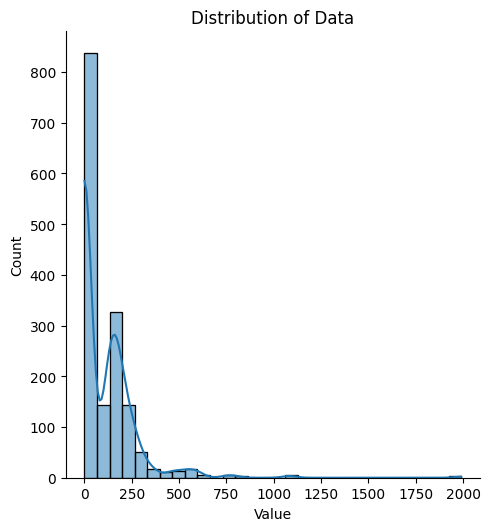

In [10]:
data = y_test_np[:,126]
sns.displot(data, kde=True, bins=30)
plt.title('Distribution of Data')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [11]:
value = 10
columns_with_values_gt_value = np.where(np.any(y_test_np > value, axis=0))[0]

print(f"Total Unit Price Columns: {len(y_test_np)}")
print(f"Unit Price Columns with at least one value greater than {value}: {len(columns_with_values_gt_value)}")


Total Unit Price Columns: 1586
Unit Price Columns with at least one value greater than 10: 933


In [12]:
EligiblePayItemIndexes = pd.read_csv("../eligibleBidItems.csv")
EligiblePayItemIndexes = EligiblePayItemIndexes.rename(columns={'0': 'ITEM NO.'})
GADOTPayItemIndexes = pd.read_csv("../PayItemIndex_2021.csv")

In [13]:
print(EligiblePayItemIndexes.head())
print(GADOTPayItemIndexes.head())


   ITEM NO.
0  009-3000
1  110-1000
2  149-0100
3  150-0008
4  150-0009
   ITEM NO. UNITS LS UNITS                                DESCRIPTION
0  001-1000     *      NaN                          FORCE ACCOUNT NO.
1  001-1900   *$*      NaN  STATE AID PROJECT - LIMITED PARTICIPATION
2  001-1999   *$*      NaN        CONSTRUCTION ENGINEERING INSPECTION
3  001-2000    WD      NaN                   CONSTRUCTION ENGINEERING
4  001-2001    HR      NaN                           SENIOR INSPECTOR


In [14]:
#unitpricecolumn = random.sample(list(columns_with_values_gt_value), k=1)[0]
#unitpricecolumn
merged_items = pd.merge(EligiblePayItemIndexes, GADOTPayItemIndexes[['ITEM NO.', 'DESCRIPTION']], 
                        on='ITEM NO.', how='left')
asphalt_columns = []
for unitpricecol in range(0, y_test.shape[1]):
    GADOTitem = merged_items.iloc[unitpricecol]
    if 'ASPH' in str(GADOTitem['DESCRIPTION']):
        asphalt_columns.append(unitpricecol)
# Only attempt to sample if asphalt_columns is not empty
print(asphalt_columns)
if asphalt_columns:
    unitpricecolumn = random.sample(asphalt_columns, k=1)[0]
    print(unitpricecolumn)
else:
    print("No asphalt columns found")
unitpricecolumn=124


[1, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 154, 155, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 194, 288, 1866]
129


In [15]:
def calculate_sample_weights(y, zero_weight=0.1, non_zero_scale=1.0):
    # Start with a base weight of 1 for all samples
    weights = np.ones_like(y)
    
    # Assign lower weight to zero values
    weights[y == 0] = zero_weight
    
    # For non-zero values, assign weights based on their magnitude
    non_zero_mask = y != 0
    weights[non_zero_mask] = non_zero_scale * (1 + np.log1p(np.abs(y[non_zero_mask])))
    
    # Normalize weights
    weights /= np.mean(weights)
    
    return weights

In [16]:
sample_weights_scaled = calculate_sample_weights(y_train_scaled[:, unitpricecolumn], zero_weight=0.1, non_zero_scale=2.0)
sample_weights = calculate_sample_weights(y_train[:, unitpricecolumn], zero_weight=0.1, non_zero_scale=2.0)

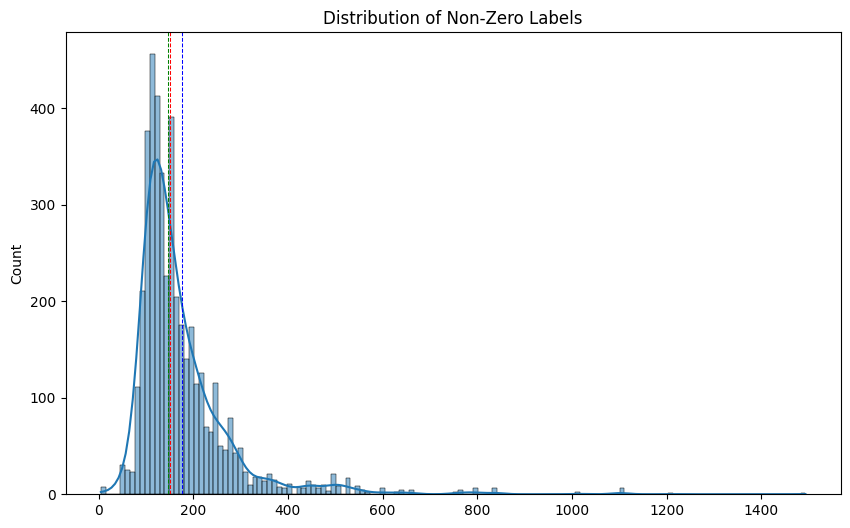

In [17]:
plt.figure(figsize=(10, 6))
nonzerolabels = y_train[:, unitpricecolumn] != 0
sns.histplot(y_train[nonzerolabels, unitpricecolumn], kde=True)

mode_result = stats.mode(y_train[nonzerolabels, unitpricecolumn])
mode = mode_result.mode
median = np.median(y_train[nonzerolabels, unitpricecolumn])
mean = np.mean(y_train[nonzerolabels, unitpricecolumn])

plt.axvline(mode, color='red', linestyle='dashed', linewidth=.75, label=f'Mode: {mode:.2f}')
plt.axvline(median, color='green', linestyle='dashed', linewidth=.75, label=f'Median: {median:.2f}')
plt.axvline(mean, color='blue', linestyle='dashed', linewidth=.75, label=f'Mean: {mean:.2f}')
plt.title('Distribution of Non-Zero Labels')
plt.show()

In [18]:
y_binary = (y_train[:, unitpricecolumn] != 0).astype(int)
smoteenn = SMOTEENN(random_state=42)
clf = RandomForestClassifier(
    n_estimators=400,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    max_features=None
)


model = GradientBoostingRegressor(
        validation_fraction=0.1, 
        loss='huber',
        verbose=1,
        n_estimators=100, # change back to 200
        n_iter_no_change=10,
        subsample=0.9,
        max_depth=30,
        learning_rate=0.01,
        random_state=42
)


model_secondstring = KNeighborsRegressor(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    n_jobs=-1,
    leaf_size=50,
)

model_thirdstring = RandomForestRegressor(
    n_estimators=400,
    criterion='friedman_mse',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

model_fourthstring = XGBRegressor(
    objective='reg:tweedie', 
    tweedie_variance_power=1.7,
    max_depth=5,
    n_estimators=100,
    n_jobs=-1
)


""" model = HistGradientBoostingRegressor(loss="quantile",
                                      quantile=0.1,
                                      max_iter=100,
                                      validation_fraction=0.1,
                                      n_iter_no_change=20,
                                      verbose=1,
                                      random_state=42,
                                      max_leaf_nodes=1000,
                                     )
"""
X_train_resampled, y_binary_train_resampled = smoteenn.fit_resample(X_train, y_binary)
clf.fit(X_train_resampled, y_binary_train_resampled)

y_pred_binary_train = clf.predict(X_train)
y_pred_binary_test = clf.predict(X_test)
accuracy = accuracy_score((y_test[:, unitpricecolumn] != 0).astype(int), y_pred_binary_test)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report((y_test[:, unitpricecolumn] !=0).astype(int), y_pred_binary_test))

mask_train = y_pred_binary_train != 0
model.fit(X_train_scaled[mask_train], y_train_scaled[mask_train,unitpricecolumn])
#scores = cross_val_score(model, X_train_scaled, y_train_scaled[:,unitpricecolumn], cv=5, scoring='neg_mean_squared_error')
#print(f'Gradient Booting Regressor Scores: {scores}')
model_secondstring.fit(X_train[mask_train], y_train[mask_train,unitpricecolumn])
#scores = cross_val_score(model_backup, X_train, y_train[:,unitpricecolumn], cv=5, scoring='neg_mean_squared_error')
#print(f'K Neighbors Regressor Scores: {scores}')
model_thirdstring.fit(X_train[mask_train], y_train[mask_train, unitpricecolumn])
model_fourthstring.fit(X_train[mask_train], y_train[mask_train, unitpricecolumn])



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   14.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished


Accuracy: 0.9874

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1008
           1       1.00      0.97      0.98       578

    accuracy                           0.99      1586
   macro avg       0.99      0.98      0.99      1586
weighted avg       0.99      0.99      0.99      1586

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2996          -0.1021           22.79s
         2           0.2944           0.0110           22.44s
         3           0.2854          -0.0240           22.23s
         4           0.2756          -0.0316           21.71s
         5           0.2705           0.0095           21.46s
         6           0.2659           0.0115           21.24s
         7           0.2674           0.0688           21.05s
         8           0.2682           0.0586           20.76s
         9           0.2556          -0.0625           20.62s
        10 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    7.3s finished


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [19]:
mask_test = y_pred_binary_test != 0
y_preds = np.zeros_like(y_test[:, unitpricecolumn])
y_preds_secondstring = np.zeros_like(y_test[:, unitpricecolumn])
y_preds_thirdstring = np.zeros_like(y_test[:, unitpricecolumn])
y_preds_fourthstring = np.zeros_like(y_test[:, unitpricecolumn])

y_preds[mask_test] = model.predict(X_test_scaled[mask_test])
y_preds_secondstring[mask_test] = model_secondstring.predict(X_test[mask_test])
y_preds_thirdstring[mask_test] = model_thirdstring.predict(X_test[mask_test])
y_preds_fourthstring[mask_test] = model_fourthstring.predict(X_test[mask_test])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished


In [20]:
def inverse_transform_Y_preds(unit_price_column: int, y_preds: np.array) -> np.array:
    n = unit_price_column  # The column you're predicting
    
    # Create a dummy array the size of your original combined dataset
    dummy_array = np.zeros((len(y_combined), y_scaler.n_features_in_))
    
    # Fill in the known values from your training set
    dummy_array[:len(y_train_scaled)] = y_scaler.transform(y_train_scaled)
    
    # Add your predictions for the test set
    dummy_array[len(y_train_scaled):, n] = y_preds
    
    # Inverse transform
    inverse_transformed = y_scaler.inverse_transform(dummy_array)
    
    # Extract only the relevant portion (the test set predictions)
    original_scale_predictions = np.round(inverse_transformed[len(y_train_scaled):, n],decimals=0)
    return original_scale_predictions


In [21]:
UnitPrice_model_predictions = inverse_transform_Y_preds(unit_price_column=unitpricecolumn, y_preds=y_preds)
UnitPrice_model_predictions_secondstring = np.round(y_preds_secondstring, decimals=0)
UnitPrice_model_predictions_thirdstring = np.round(y_preds_thirdstring, decimals=0)
UnitPrice_model_predictions_fourthstring = np.round(y_preds_fourthstring, decimals=0)

In [22]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = np.square(error) / 2
    linear_loss = delta * (np.abs(error) - delta / 2)
    return np.where(is_small_error, squared_loss, linear_loss).mean()

In [24]:
y_huber = huber_loss(y_test[:, unitpricecolumn], UnitPrice_model_predictions)
y_huber_secondstring = huber_loss(y_test[:, unitpricecolumn], UnitPrice_model_predictions_secondstring)
y_huber_thirdstring = huber_loss(y_test[:, unitpricecolumn], UnitPrice_model_predictions_thirdstring)
y_huber_fourthstring = huber_loss(y_test[:, unitpricecolumn], UnitPrice_model_predictions_fourthstring)
huberdict = {
    "Gradient Boosting": y_huber,
    "K Means Regression": y_huber_secondstring,
    "Random Tree Regression": y_huber_thirdstring,
    "XGB Regressor Tweedie": y_huber_fourthstring
}

# Sort the dictionary by values (Huber loss)
sorted_huber = sorted(huberdict.items(), key=lambda x: x[1])

# Get the best, second-best, and third-best models
best_model, best_huber = sorted_huber[0]
second_best_model, second_best_huber = sorted_huber[1]
third_best_model, third_best_huber = sorted_huber[2]
fourth_best_model, fourth_best_huber = sorted_huber[3]

# Select the model based on Huber loss
if best_model == "Gradient Boosting":
    print("USE GRADIENT BOOSTING MODEL")
    selected_predictions = UnitPrice_model_predictions
elif best_model == "K Means Regression":
    print("USE K MEANS REGRESSION MODEL")
    selected_predictions = UnitPrice_model_predictions_secondstring
elif best_model == "Random Tree Regression":
    print("USE RANDOM TREE REGRESSION MODEL")
    selected_predictions = UnitPrice_model_predictions_thirdstring
elif best_model == "XGB Regressor Tweedie":
    print("USE XGB REGRESSOR TWEEDIE")
    selected_predictions = UnitPrice_model_predictions_fourthstring

# Update y_difference based on the selected model
y_difference = selected_predictions - y_test[:, unitpricecolumn]

# Print additional information
print(f"Best model: {best_model} (Huber loss: {best_huber:.4f})")
print(f"Second-best model: {second_best_model} (Huber loss: {second_best_huber:.4f})")
print(f"Third-best model: {third_best_model} (Huber loss: {third_best_huber:.4f})")
print(f"Fourth-best model: {fourth_best_model} (Huber loss: {fourth_best_huber:.4f})")


USE XGB REGRESSOR TWEEDIE
Best model: XGB Regressor Tweedie (Huber loss: 34.4648)
Second-best model: Random Tree Regression (Huber loss: 36.0207)
Third-best model: Gradient Boosting (Huber loss: 39.4493)
Fourth-best model: K Means Regression (Huber loss: 45.6031)


In [25]:
def createResultsDataframe(unitpricecolumn, UnitPrice_model_predictions, y_difference):
    pred_dict = {}
    pred_dict["Y True"]  = y_test[:,unitpricecolumn]
    
    pred_dict["Y Pred"] = UnitPrice_model_predictions
    
    pred_dict["Difference"] = y_difference
    epsilon = 1e-10  # A small number to avoid division by zero
    pred_dict["% Difference True"] = (abs(pred_dict["Difference"]) / (pred_dict["Y True"] + epsilon)) * 100
    dataframe = pd.DataFrame.from_dict(pred_dict, orient='index').T.astype(float)
    return dataframe

In [26]:
yTruePredDiffDataframe = createResultsDataframe(unitpricecolumn=unitpricecolumn, 
                                                UnitPrice_model_predictions=selected_predictions, 
                                                y_difference=y_difference)
yTruePredDiffDataframe

Y True  Y Pred  Difference  % Difference True
0       0.00     0.0        0.00           0.000000
1       0.00     0.0        0.00           0.000000
2       0.00     0.0        0.00           0.000000
3       0.00     0.0        0.00           0.000000
4       0.00     0.0        0.00           0.000000
...      ...     ...         ...                ...
1581  149.37   163.0       13.63           9.124992
1582  185.00   171.0      -14.00           7.567568
1583  198.00   187.0      -11.00           5.555556
1584  149.37   163.0       13.63           9.124992
1585  207.10   218.0       10.90           5.263158

[1586 rows x 4 columns]

In [27]:
yTruePredDiffDataframe[yTruePredDiffDataframe['Y True'] > 0]

Y True  Y Pred  Difference  % Difference True
144   145.00   161.0       16.00          11.034483
145   170.23   153.0      -17.23          10.121600
188   302.02   268.0      -34.02          11.264155
189   344.00   323.0      -21.00           6.104651
198   240.00   229.0      -11.00           4.583333
...      ...     ...         ...                ...
1581  149.37   163.0       13.63           9.124992
1582  185.00   171.0      -14.00           7.567568
1583  198.00   187.0      -11.00           5.555556
1584  149.37   163.0       13.63           9.124992
1585  207.10   218.0       10.90           5.263158

[578 rows x 4 columns]

In [28]:
yTruePredDiffDataframe[(yTruePredDiffDataframe["% Difference True"] > 30)]

Y True  Y Pred  Difference  % Difference True
202   551.08   310.0     -241.08          43.746824
204   154.81   394.0      239.19         154.505523
206   154.81   391.0      236.19         152.567664
207   551.08   307.0     -244.08          44.291210
260   152.54   219.0       66.46          43.568900
...      ...     ...         ...                ...
1451  450.00   261.0     -189.00          42.000000
1548  540.50   279.0     -261.50          48.381129
1551  293.57   203.0      -90.57          30.851245
1572  168.86   239.0       70.14          41.537368
1573  175.00   233.0       58.00          33.142857

[180 rows x 4 columns]

In [29]:
len(yTruePredDiffDataframe[abs(yTruePredDiffDataframe["Difference"]) > (0.10 * yTruePredDiffDataframe["Y True"])])

414

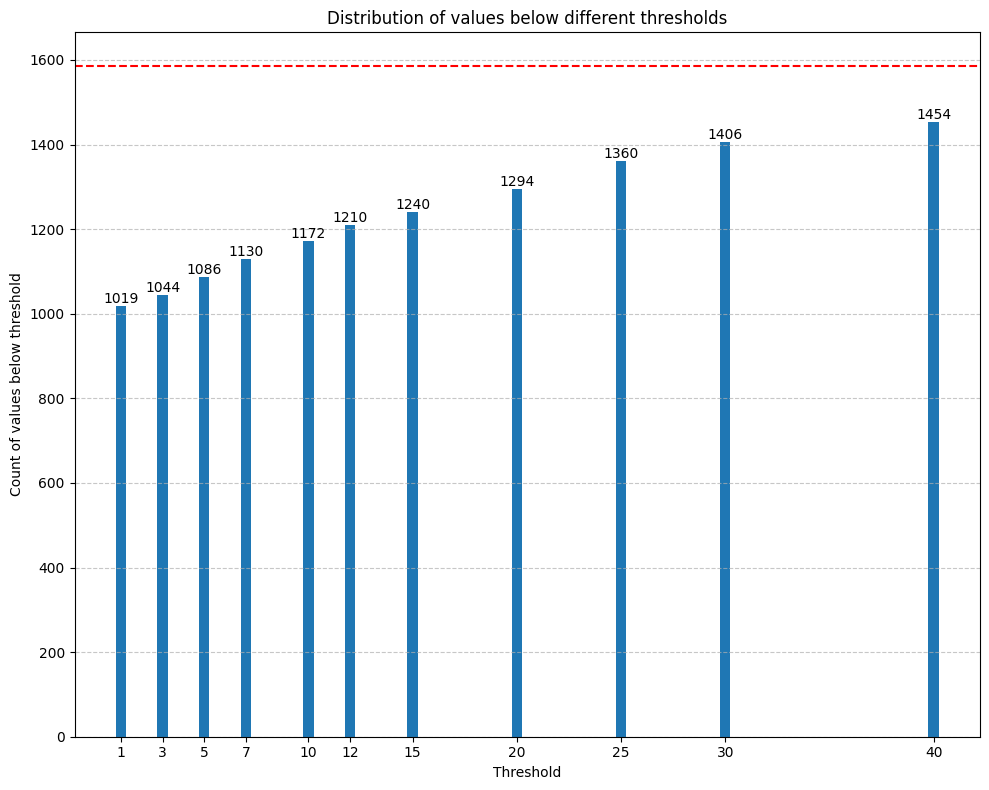

Unit ITEM: 402-1802
	DESC: RECYCLED ASPH CONC PATCHING, INCL BITUM MATL & H LIME
Total Examples: 1586
Less than 1% Error: 1019 (64.25% of Examples)
Less than 3% Error: 1044 (65.83% of Examples)
Less than 5% Error: 1086 (68.47% of Examples)
Less than 7% Error: 1130 (71.25% of Examples)
Less than 10% Error: 1172 (73.9% of Examples)
Less than 12% Error: 1210 (76.29% of Examples)
Less than 15% Error: 1240 (78.18% of Examples)
Less than 20% Error: 1294 (81.59% of Examples)
Less than 25% Error: 1360 (85.75% of Examples)
Less than 30% Error: 1406 (88.65% of Examples)
Less than 40% Error: 1454 (91.68% of Examples)


In [30]:
# Define the range of thresholds you want to check
thresholds = [1, 3, 5, 7, 10, 12, 15, 20, 25, 30, 40]  # This will check from 0 to 100 in steps of 5

# List to store the counts
counts = []

# Loop through the thresholds and count values below each
for threshold in thresholds:
    count = len(yTruePredDiffDataframe[abs(yTruePredDiffDataframe["Difference"]) <= (threshold/100)*yTruePredDiffDataframe["Y True"]])
    counts.append(count)

# Create the histogram
plt.figure(figsize=(10, 8))
plt.bar(thresholds, counts, width=0.5)
plt.xlabel('Threshold')
plt.ylabel('Count of values below threshold')
plt.title('Distribution of values below different thresholds')
plt.xticks(thresholds[::1])  # Show every other threshold on x-axis for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=len(yTruePredDiffDataframe), color='red', linestyle='--')

# Add value labels on top of each bar
for i, count in enumerate(counts):
    plt.text(thresholds[i], count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# If you want to see the actual counts
print(f"Unit ITEM: {merged_items['ITEM NO.'].iloc[unitpricecolumn]}")
print(f"\tDESC: {merged_items['DESCRIPTION'].iloc[unitpricecolumn]}")
print(f'Total Examples: {len(yTruePredDiffDataframe)}')
for threshold, count in zip(thresholds, counts):
    print(f"Less than {threshold}% Error: {count} ({round((count/len(yTruePredDiffDataframe))*100,2)}% of Examples)")

# Worst Performing Asphalt Columns

__Column 124__ ->  _402-1802: RECYCLED ASPH CONC PATCHING, INCL BITUM MATL & H LIME_
* Less than 1% Error: 3209 (67.77% of Examples)
* Less than 3% Error: 3254 (68.72% of Examples)
* Less than 5% Error: 3300 (69.69% of Examples)
* Less than 7% Error: 3362 (71.0% of Examples)
* Less than 10% Error: 3426 (72.35% of Examples)
* Less than 12% Error: 3458 (73.03% of Examples)
* Less than 15% Error: 3529 (74.53% of Examples)
* Less than 20% Error: 3664 (77.38% of Examples)


__Column 126__ -> _402-1812 RECYCLED ASPH CONC LEVELING, INCL BITUM MATL & H LIME_
* Less than 1% Error: 2490 (52.59% of Examples)
* Less than 3% Error: 2543 (53.71% of Examples)
* Less than 5% Error: 2584 (54.57% of Examples)
* Less than 7% Error: 2663 (56.24% of Examples)
* Less than 10% Error: 2760 (58.29% of Examples)
* Less than 12% Error: 2842 (60.02% of Examples)
* Less than 15% Error: 2950 (62.3% of Examples)
* Less than 20% Error: 3144 (66.4% of Examples)
                

__Column 134__ -> _402-3121 RECYCLED ASPH CONC 25 MM SUPERPAVE, GP 1 OR 2, INCL BITUM MATL & H LIME_
* Less than 1% Error: 2564 (54.15% of Examples)
* Less than 3% Error: 2605 (55.02% of Examples)
* Less than 5% Error: 2657 (56.11% of Examples)
* Less than 7% Error: 2685 (56.71% of Examples)
* Less than 10% Error: 2747 (58.01% of Examples)
* Less than 12% Error: 2812 (59.39% of Examples)
* Less than 15% Error: 2941 (62.11% of Examples)
* Less than 20% Error: 3173 (67.01% of Examples)

__Column 135__ -> _402-3130 RECYCLED ASPH CONC 12.5 MM SUPERPAVE, GP 2 ONLY, INCL BITUM MATL & H LIME_
* Less than 1% Error: 3615 (76.35% of Examples)
* Less than 3% Error: 3655 (77.19% of Examples)
* Less than 5% Error: 3681 (77.74% of Examples)
* Less than 7% Error: 3701 (78.16% of Examples)
* Less than 10% Error: 3744 (79.07% of Examples)
* Less than 12% Error: 3766 (79.54% of Examples)
* Less than 15% Error: 3800 (80.25% of Examples)
* Less than 20% Error: 3865 (81.63% of Examples)

__Column 138__ -> _402-3190 RECYCLED ASPH CONC 19 MM SUPERPAVE, GP 1 OR 2,INCL BITUM MATL & H LIME_
* Less than 1% Error: 2479 (52.35% of Examples)
* Less than 3% Error: 2515 (53.12% of Examples)
* Less than 5% Error: 2556 (53.98% of Examples)
* Less than 7% Error: 2608 (55.08% of Examples)
* Less than 10% Error: 2668 (56.35% of Examples)
* Less than 12% Error: 2737 (57.8% of Examples)
* Less than 15% Error: 2862 (60.44% of Examples)
* Less than 20% Error: 3100 (65.47% of Examples)